In [1]:
import torch
import torch.nn as nn
import numpy as np
import random
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import pandas as pd

## Setting seed

In [2]:
def set_seed(seed_value=42):
    """
    Set random seed across NumPy, Python, and PyTorch to ensure reproducibility.

    Args:
        seed_value (int): The seed value to use. Default is 42, a commonly used arbitrary number.

    This function ensures that experiments produce the same results across different runs,
    which is critical for debugging, comparing models, and scientific reproducibility.

    It sets the seed for:
        - NumPy (used for numerical ops like matrix generation)
        - Python's built-in random module (used in random sampling, shuffling, etc.)
        - PyTorch (both CPU and GPU)

    For GPU reproducibility:
        - It manually sets the CUDA seeds (for single and multi-GPU setups)
        - It disables the CUDA backend benchmarking feature to ensure deterministic behavior
          (at the potential cost of performance).
    """

    # Set seed for NumPy (used in data shuffling, batch generation, etc.)
    np.random.seed(seed_value)

    # Set seed for PyTorch operations on CPU
    torch.manual_seed(seed_value)

    # Set seed for Python's built-in random module (e.g., random.shuffle, random.randint)
    random.seed(seed_value)

    # Set seeds for PyTorch operations on GPU
    if torch.cuda.is_available():
        print("Cuda is available. Setting GPU seed.")
        # Set seed for single-GPU
        torch.cuda.manual_seed(seed_value)

        # Set seed for all available GPUs (multi-GPU training)
        torch.cuda.manual_seed_all(seed_value)

        # Ensures that CUDA uses deterministic algorithms
        # This disables non-deterministic optimizations and ensures reproducible behavior
        torch.backends.cudnn.deterministic = True

        # Disables cuDNN auto-tuner which selects the best algorithm for each configuration
        # When disabled, it uses deterministic algorithms, but this might make training slower
        torch.backends.cudnn.benchmark = False

# Set the seed globally so every run starts from the same state
set_seed(42)

## I) Create target and predictors

In [3]:
def create_target_predictors(dataframe: pd.DataFrame, target_col: str = "RETURN", n_lags = 10):

    for lag in range(1, n_lags + 1):
        dataframe[f'lag_{lag}'] = dataframe[target_col].shift(lag)

    dataframe.dropna(inplace=True)

    predictors = dataframe[[f'lag_{lag}' for lag in range(1, n_lags + 1)]].copy()
    predictors = predictors.values
    target = dataframe[target_col].values

    return predictors, target

## II) Train and test split

In [4]:
def get_train_and_test_data(signals, labels, split_percentage):
        
    split = int(split_percentage * signals.shape[0])

    train_labels = labels[:split]
    test_labels = labels[split:]

    train_data = signals[:split, :]
    test_data = signals[split:, :]

    return train_data, test_data, train_labels, test_labels

## III) Use the real data

In [5]:
df = pd.read_parquet("/Users/nicolobaldovin/Desktop/EPFL/MachineLearninginFinance/High-Frequency-Trading-with-Deep-Learning/data/high_10m.parquet")
df.head()

,DATE,SYMBOL,TIME,ALL_EX,MID_OPEN,SUM_DELTA,RETURN
0,2021-12-01,A,09:30:00,DNYBTJVPCZUKXHA,152.190,-8.401819,0.000000
1,2021-12-01,A,09:40:00,PBTJVDZUYKNHCXM,150.490,0.473357,-0.011170
2,2021-12-01,A,09:50:00,KDPBTJVNZUCXYH,151.475,-10.867709,0.006545
3,2021-12-01,A,10:00:00,DABTJNKYVPZUXCH,150.510,-0.125414,-0.006371
4,2021-12-01,A,10:10:00,DVJTPNKUZYACBXHM,151.960,-1.274648,0.009634


In [ ]:
df = df[df["SYMBOL"] == "A"]
df = df.drop(columns=["DATE", "SYMBOL", "TIME", "ALL_EX", "MID_OPEN", "SUM_DELTA"])
df.head()

predictors, labels = create_target_predictors(df, target_col="RETURN", n_lags=10)

In [7]:
X_train, X_test, y_train, y_test = get_train_and_test_data(predictors, labels, split_percentage=0.8)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Wrap the input and label tensors into TensorDatasets for PyTorch
# This allows easy batching and iteration
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# DataLoaders make it easy to loop over the dataset in mini-batches
# - batch_size=32: standard default, can be tuned
# - shuffle=True: randomly shuffles training data each epoch for better generalization
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# For evaluation, we typically do not shuffle test data
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

## IV) Class for the neural network

In [8]:
class Intraday_trading(nn.Module):
    def __init__(self, layers: list, scale: float = 1.0, bias_scale: float = 0.0, activation=nn.GELU()):
        """
        Initialize a customizable Multi-Layer Perceptron (MLP) with flexible architecture and initialization.

        Args:
            layers (list of int): A list of integers where each value defines the size of each layer.
                                  For example, layers=[10, 64, 32, 1] defines a network with input dimension 10,
                                  two hidden layers with sizes 64 and 32, and output dimension 1.
            scale (float): Scaling factor for weight initialization. Controls the standard deviation of
                           the normal distribution used in initializing weights. Recommended to be 1.0 for LeCun initialization.
            bias_scale (float): Scaling factor for bias initialization. Often set to 0.0 to start with no initial bias.
            activation (nn.Module): Activation function applied after each linear transformation except the last layer.
                                    Defaults to nn.GELU(), but can be any activation like nn.ReLU(), nn.Tanh(), etc.
        """
        # Call the constructor of the parent class (nn.Module) to initialize all internal PyTorch machinery.
        # This is crucial because nn.Module handles a lot of behind-the-scenes logic like:
        # - registering parameters (weights and biases) for automatic optimization
        # - setting up .to(device), .eval(), .train(), etc.
        # - tracking submodules (layers, activations, etc.)
        #
        # If you omit this line, the module will NOT work correctly in PyTorch:
        # things like model.cuda(), model.parameters(), model.state_dict(), etc. will all break.
        #
        # The super() call here:
        # - FlexibleMLP is our class
        # - nn.Module is the parent class
        # - self.__init__() is the method we want to call from the parent
        super(Intraday_trading, self).__init__()   # Chiamo l'__init__ del nn.Module e lo metto nel self di FlexibleMLP

        # Save arguments as attributes for reuse in reset_parameters
        self.layer_sizes = layers
        self.scale = scale
        self.bias_scale = bias_scale
        self.activation_fn = activation

        # Create containers to hold layers and activations
        self.layers = nn.ModuleList()
        self.activations = nn.ModuleList()

        # Build network structure (but not weights yet)
        self._build_layers()

        # Initialize weights and biases
        self.reset_parameters()

    def _build_layers(self):
        """
        Build the linear layers and corresponding activations (except for initialization).
        """
        for i in range(len(self.layer_sizes) - 1):
            # Create a linear layer from layer i to layer i+1
            layer = nn.Linear(self.layer_sizes[i], self.layer_sizes[i + 1])
            self.layers.append(layer)

            # Add an activation function unless it's the final layer
            if i < len(self.layer_sizes) - 2:
                self.activations.append(self.activation_fn)
            else:
                # Final layer doesn't use activation (use Identity to keep list structure consistent)
                self.activations.append(nn.Identity())

    def reset_parameters(self):
        """
        Apply custom initialization to all layers using the given scale and bias_scale.
        """
        for i, layer in enumerate(self.layers):
            # Apply LeCun-style initialization for better gradient behavior
            nn.init.normal_(layer.weight, mean=0.0, std=self.scale * np.sqrt(1 / self.layer_sizes[i]))
            nn.init.normal_(layer.bias, mean=0.0, std=self.bias_scale * np.sqrt(1 / self.layer_sizes[i]))

    def forward(self, x, return_last_hidden=False):
        """
        Perform a forward pass through the network.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, input_dim).
            return_last_hidden (bool): If True, returns both the final output and the last hidden layer's output.
                                       Useful for feature extraction, analysis, or interpretability.

        Returns:
            torch.Tensor: Output of the final layer.
            torch.Tensor (optional): Output of the last hidden layer (before final linear layer),
                                     if return_last_hidden is set to True.
        """
        last_hidden = None  # Will store the output of the last hidden layer

        # Apply all but the last layer with activation
        for layer, activation in zip(self.layers[:-1], self.activations[:-1]):
            x = activation(layer(x))  # Apply linear transformation and activation
            # x = activation(layer.forward(x))
            last_hidden = x  # Save the last hidden output

        # Final layer (linear transformation only, no activation)
        x = self.layers[-1](x)

        if return_last_hidden:
            return x, last_hidden
        return x




## V) Training model

In [9]:
def train_model(num_epochs: int,
                train_loader: torch.utils.data.DataLoader,
                criterion,
                optimizer,
                model: torch.nn.Module,
                ridge_penalty: float = 0.001):
    """
    Train a PyTorch model using mini-batch gradient descent with optional L2 (ridge) regularization.

    Args:
        num_epochs (int): Number of full passes through the training dataset.
        train_loader (DataLoader): PyTorch DataLoader containing training data in mini-batches.
        criterion: Loss function (e.g., nn.MSELoss).
        optimizer: PyTorch optimizer (e.g., torch.optim.Adam or SGD).
        model (nn.Module): The model to train.
        ridge_penalty (float): L2 regularization strength (default: 0.001). Helps reduce overfitting.

    Returns:
        None. Prints training loss every 20 epochs.
    """
    for epoch in range(num_epochs):
        for inputs, targets in train_loader:
            # Forward pass: get model predictions for this batch
            outputs = model(inputs)

            # Compute loss = prediction error + ridge penalty (L2 regularization)
            # The penalty term prevents overfitting by discouraging large weights
            # sum(p.abs().pow(2).sum()) is equivalent to ||W||² (squared L2 norm)
            loss = criterion(outputs, targets) + ridge_penalty * sum(p.pow(2.0).sum() for p in model.parameters())

            # Backward pass and optimization:
            optimizer.zero_grad()   # Clear previous gradients to prevent accumulation
            loss.backward()         # Backpropagate the current loss
            optimizer.step()        # Perform a parameter update (gradient descent step)

        # Print progress every 20 epochs
        if (epoch + 1) % 20 == 0:
            print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')


## VI) Do the DNN

In [10]:
layer_sizes = [10, 32, 1]
model = Intraday_trading(layer_sizes, scale=2., bias_scale=0.)
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.1)

In [11]:
# Ensure the model is in evaluation mode
# Function to get predictions
def get_predictions(loader, model):
    model.eval()
    targets = []
    predictions = []

    with torch.no_grad():
        for inputs, labels in loader:
            outputs = model(inputs)
            targets.extend(labels.numpy())
            predictions.extend(outputs.numpy())

    return np.array(targets).flatten(), np.array(predictions).flatten()

# Get predictions for both training and test sets
train_sample = get_predictions(train_loader, model)
test_sample = get_predictions(test_loader, model)
train_targets = train_sample[0][0]


In [12]:
test_targets = test_sample[0][0]

In [13]:
train_predictions = train_sample[1]
test_predictions = test_sample[1]

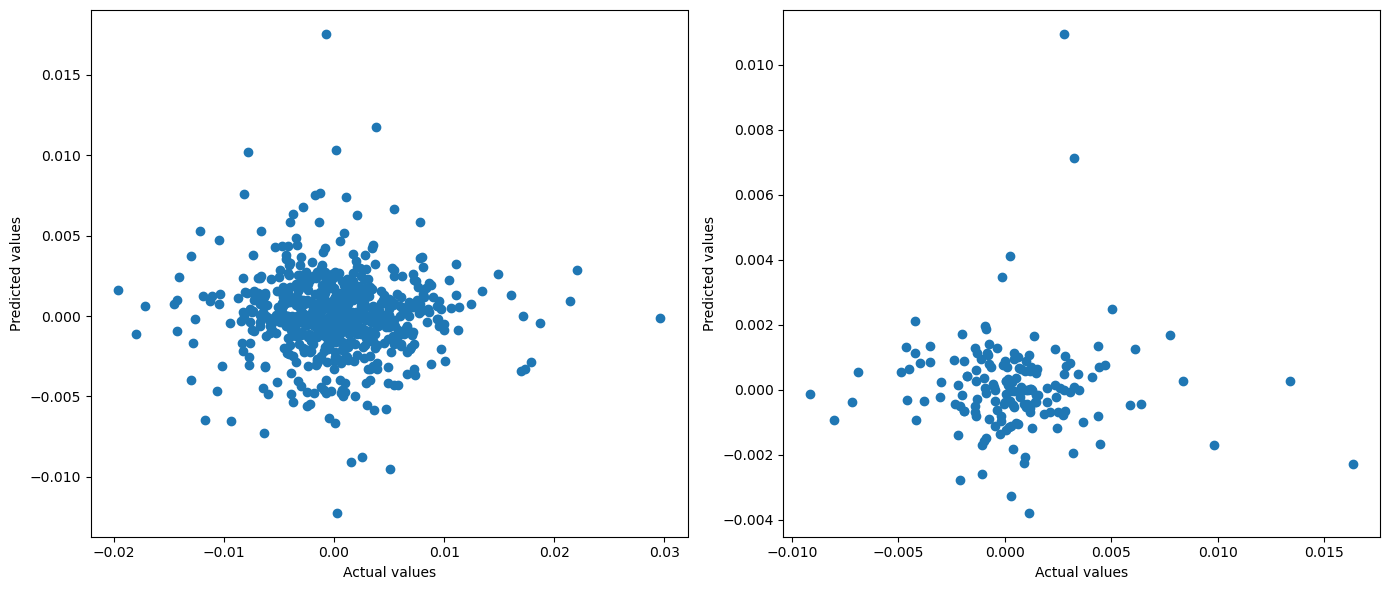

In [14]:
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Training set subplot
axs[0].scatter(train_sample[1], y_train)
axs[0].plot([train_targets.min(), train_targets.max()], [train_targets.min(), train_targets.max()], 'k--', lw=2)  # Diagonal line
axs[0].set_xlabel('Actual values')
axs[0].set_ylabel('Predicted values')

# Test set subplot
axs[1].scatter(test_sample[1], y_test) #.mean(1))
axs[1].plot([test_targets.min(), test_targets.max()], [test_targets.min(), test_targets.max()], 'k--', lw=2)  # Diagonal line
axs[1].set_xlabel('Actual values')
axs[1].set_ylabel('Predicted values')

plt.tight_layout()
plt.show()